# VQLS for Simple Harmonic Oscillator

In [17]:
import numpy as np
import matplotlib.pyplot as plt

#Create matrix A
n1 = 4
w = 1
h = 0.01 #Step Size

A1 = np.zeros((n1,n1))
for i in range(n1):
    A1[i,i] = 1
A1[2,0] = -1
A1[2,1] = - h
A1[3,0] = h*w*w
A1[3,1] = -1

print("A_matrix:",A1)

A1_dag = A1.conj().T

print("A^dagger:",A1_dag)

n= 2*n1
Amat = np.zeros((n,n))
for i in range(n1):
    for j in range(n1,n):
        Amat[i,j] = A1[i,j-n1]

for i in range(n1,n):
    for j in range(n1):
        Amat[i,j] = A1_dag[i-n1,j]

print("A_final:", Amat)

print("Condition number of Amat:", np.linalg.cond(Amat))


A_matrix: [[ 1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [-1.   -0.01  1.    0.  ]
 [ 0.01 -1.    0.    1.  ]]
A^dagger: [[ 1.    0.   -1.    0.01]
 [ 0.    1.   -0.01 -1.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
A_final: [[ 0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.   -1.   -0.01  1.    0.  ]
 [ 0.    0.    0.    0.    0.01 -1.    0.    1.  ]
 [ 1.    0.   -1.    0.01  0.    0.    0.    0.  ]
 [ 0.    1.   -0.01 -1.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.  ]]
Condition number of Amat: 2.6181510698948482


## One step VQLS

Is Hermitian? True
Imag part of coeffs: 0.5


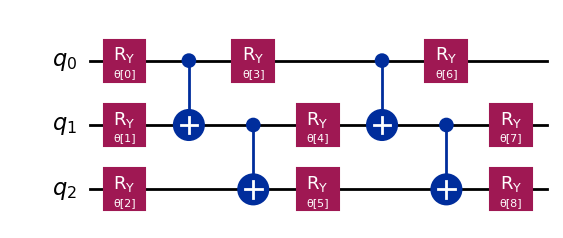

Optimal Parameters: [3.23301872 3.99417366 4.7108371  4.45706511 7.01856042 6.28421977
 5.03494509 3.20464865 4.71301254]
Minimum Cost: 1.6211316794158778e-07


In [2]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix
from qiskit.circuit.library import TwoLocal,n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I3 = SparsePauliOp.from_list([("III", 1.0)])

#Step 1: Operator A
#A_mat = np.array([[4,1,0,0],[1,3,1,0],[0,1,2,1],[0,0,1,1]])
A_op = SparsePauliOp.from_operator(Amat)

#Step 2: |b> vector normalized, encoding in circuit and creating a density matrix |b><b|
bvec = [1,0,0,0]
Bvec1 = np.zeros(n)
for i in range(n1):
    Bvec1[i] = bvec[i]
norm1 = np.linalg.norm(Bvec1)
B_vec = Bvec1 / norm1
B_mat = DensityMatrix(B_vec)
B_op = SparsePauliOp.from_operator(B_mat)

#step 3: Cost Hamiltonian
Ham = A_op @ (I3 - B_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
#print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz (two-local circuit)

ansatz = n_local(3, rotation_blocks="ry", entanglement_blocks="cx", entanglement="linear", reps=2)
display(ansatz.draw("mpl"))

#Step 5: evaluate cost function
def costfunc(params):
    #state = ansatz.bind_parameters(params)
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
result = minimize(costfunc, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)


In [36]:
# To create the statevector from above optimal values
from qiskit.quantum_info import Statevector

# Create circuit with optimal parameters
optimal_params = result.x
optimal_circuit = ansatz.assign_parameters(optimal_params)

# Get statevector from the circuit
statevector = Statevector.from_instruction(optimal_circuit)

# Show vector (solution |x⟩)
print("Approximate solution |x⟩:", statevector.data)
print("final sol:", statevector[4])
display(statevector.draw("latex"))


Approximate solution |x⟩: [ 1.75647340e-05+0.j -4.17244606e-04+0.j -2.91765621e-05+0.j
 -3.83056180e-04+0.j  7.07103818e-01+0.j  8.92812188e-05+0.j
  7.07109506e-01+0.j  8.42680614e-05+0.j]
final sol: (0.7071038179289543+0j)


<IPython.core.display.Latex object>

In [18]:
#Classsical Solution
# Original A matrix
Acl = Amat

# Original b vector
bcl = Bvec1
#bcl = bcl / np.linalg.norm(bcl)

# Classical solution
x_classical = np.linalg.solve(Acl, bcl)
#x_classical = x_classical / np.linalg.norm(x_classical)  # normalized for comparison
print("Classical solution:", x_classical)
norm_cl = np.linalg.norm(x_classical)
print("norm:",norm_cl)


Classical solution: [ 0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  1.e+00 -1.e-04]
norm: 1.414213565908629


## VQLS for all steps

In [18]:
#Creating Loop with VQLS code in it
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix,Statevector
from qiskit.circuit.library import n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I3 = SparsePauliOp.from_list([("III", 1.0)])

# Defining Operator A and vector B
A_op = SparsePauliOp.from_operator(Amat)
bvec = [1,0,0,0]
Bvec1 = np.zeros(n)
for i in range(n1):
    Bvec1[i] = bvec[i]

#Define the cost function
def costfunc(params):
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#Step: Create ansatz (two-local circuit)
ansatz = n_local(3, rotation_blocks=["ry"], entanglement_blocks="cz", entanglement="circular", reps=3)


#Creating a VQLS loop
nf = 2000 #iterations
x_fin = np.zeros(nf)
y_fin = np.zeros(nf)
x_fin[0] = bvec[0] 
y_fin[0] = bvec[1]

np.random.seed(0)

for i in range(1,nf):  
    #Operator from b (|b><b|)
    norm1 = np.linalg.norm(Bvec1)
    B_vec = Bvec1 / norm1
    B_mat = DensityMatrix(B_vec)
    B_op = SparsePauliOp.from_operator(B_mat)
    
    #Cost Hamiltonian
    Ham = A_op @ (I3 - B_op) @ A_op

    #checking H is hermitian
    #print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

    #Checking any imaginary coefficients
    #print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

    # Make the operator Hermitian (just in case)
    Ham = 0.5 * (Ham + Ham.adjoint())

    # Strip all imaginary parts: only real part is needed
    Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))
    
    #step 6: optimization
    
    if i == 1:
        initial_params = np.zeros(ansatz.num_parameters)
    else:
        initial_params = optimal_params

    #initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
    result = minimize(costfunc, initial_params, method='COBYLA',options={'maxiter': 200,'tol': 1e-10})
    optimal_params = result.x
    optimal_circuit = ansatz.assign_parameters(optimal_params)
    statevector = Statevector.from_instruction(optimal_circuit)
    y_quantum = statevector.data
    #print("Minimum Cost:", result.fun)

    #Classical solution of matrix
    xhat = y_quantum
    Axhat = Amat @ xhat
    x_norm = np.linalg.norm(Bvec1)/np.linalg.norm(Axhat)
    c = np.vdot(Bvec1, Axhat) / np.vdot(Axhat, Axhat)
    #x_q = c * xhat
    x_q = x_norm * xhat
    
    #Array of solution
    x_qm = np.zeros(n)
    for k in range(n):
        x_qm[k] = x_q[k].real

    v = x_q[4:8]  # second half
    xi, yi, xip1, yip1 = v

    #print("Euler residuals:",xip1 - (xi + h*yi),yip1 - (yi - h*w*w*xi))

    #update B vector
    Bvec1[0] = x_qm[6]
    Bvec1[1] = x_qm[7]
    #print("updated Bvec:",Bvec1)
    #print(f"Sol at {i} step:{y_qm}")
    
    #Final solution
    x_fin[i] = x_qm[6]
    y_fin[i] = x_qm[7]
    #print(x_fin[i])

print("Quantum x solution:", x_fin)
print("Quantum y solution:", y_fin)



Quantum x solution: [1.         0.99996209 1.00093965 ... 0.67427884 0.66549783 0.65659844]
Quantum y solution: [ 0.00000000e+00 -8.04335331e-04 -9.32314333e-03 ... -8.84698415e-01
 -8.91371248e-01 -8.98032010e-01]


Comparison between Classical and Quantum

In [21]:
import numpy as np

h = 0.01
omega = 1.0
nf = len(x_fin)
t = np.arange(nf)*h
x_exact = np.cos(omega*t)

# explicit Euler for comparison
x_e = np.zeros(nf); y_e = np.zeros(nf)
x_e[0]=1.0; y_e[0]=0.0
for i in range(nf-1):
    x_e[i+1] = x_e[i] + h*y_e[i]
    y_e[i+1] = y_e[i] - h*(omega**2)*x_e[i]

print("x_exact:", x_exact)
print("x_euler:", x_e)
print("x_vqls :", x_fin)
print("x_res :", x_e-x_fin)


x_exact: [1.         0.99995    0.99980001 ... 0.43528269 0.42625814 0.41719096]
x_euler: [1.         1.         0.9999     ... 0.48164929 0.47170425 0.46171104]
x_vqls : [1.         0.99996209 1.00093965 ... 0.67427884 0.66549783 0.65659844]
x_res : [ 0.00000000e+00  3.79073227e-05 -1.03965481e-03 ... -1.92629556e-01
 -1.93793581e-01 -1.94887392e-01]


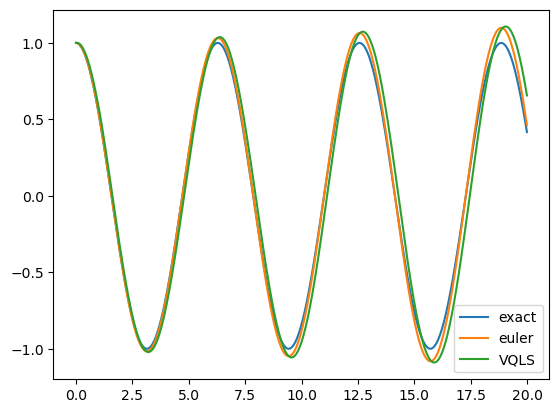

In [22]:
import matplotlib.pyplot as plt

plt.plot(t,x_exact,label='exact')
plt.plot(t,x_e,label='euler')
plt.plot(t,x_fin,label='VQLS')

plt.legend()
plt.show()